### TEST MAP

In [1]:
import os
import pandas
import numpy as np
import utm

from utils import transformation

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

### Read GPS Triggering data

In [2]:
# load data
source_folder = "../../../data/field_map/"
south_data = "2022_10_04_09_57_34/gps_at_trigger.csv"
west_data = "2022_10_04_10_48_09/gps_at_trigger.csv"
north_path = "2022_10_04_11_05_46/gps_at_trigger.csv"
east_path = "2022_10_04_11_41_05/gps_at_trigger.csv"

all_data_csv = [south_data, west_data, north_path, east_path]
all_data_name = ['south', 'west', 'north', 'east']

# raw pandas data
all_data_pt_raw = {}
for data_csv, name in zip(all_data_csv, all_data_name) :
    raw_data = pandas.read_csv(os.path.join(source_folder, data_csv))
    all_data_pt_raw[name] = (raw_data)

# field bound latlon
field_bound_latlon = (
    (-121.794980, -121.793920), # longitude
    (38.537990, 38.539540),     # latitude
)

# field origin lat, lon
field_origin = (field_bound_latlon[1][0], field_bound_latlon[0][0])
e, n, zone_number, zone_letter = utm.from_latlon(field_origin[0], field_origin[1]) 

print('easting: ' + str(e) + ', northing: ' + str(n))
print('zone number: {zone_number}, zone_letter: {zone_letter}')

T = transformation.states2SE3([e, n, 0, 0, 0, 0])
R = transformation.states2SE3([0, 0, 0, 0, 0, 0])
local_T_utm = R.dot(T)
utm_T_local = np.linalg.inv(local_T_utm)

print('utm_T_local: \n' + str(utm_T_local))

# field bound local
field_bound_local = [
    [0, 0],
    [0, 0],
]
for i in range(2):
    for j in range(2):
        e, n, _, _ = utm.from_latlon(field_bound_latlon[1][i], field_bound_latlon[0][j])
        point_local = utm_T_local.dot(np.array([e, n, 0, 1]).T)
        field_bound_local[0][0] = min(field_bound_local[0][0], point_local[0])
        field_bound_local[0][1] = max(field_bound_local[0][1], point_local[0])
        field_bound_local[1][0] = min(field_bound_local[1][0], point_local[1])
        field_bound_local[1][1] = max(field_bound_local[1][1], point_local[1])

field_bound_local = (
    (field_bound_local[0][0], field_bound_local[0][1]),
    (field_bound_local[1][0], field_bound_local[1][1]),
)

easting: 605021.7182561597, northing: 4266196.996235917
zone number: {zone_number}, zone_letter: {zone_letter}
utm_T_local: 
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -6.05021718e+05]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -4.26619700e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


### Process data

In [3]:
# convert to numpy
all_data_latlon = {}
for key in all_data_pt_raw.keys():
    all_data_latlon[key] = np.vstack((all_data_pt_raw[key].lon_avg, all_data_pt_raw[key].lat_avg)).T

# convert to utm
all_data_local = {}
for key in all_data_pt_raw.keys():
    easting, northing, _, _ = utm.from_latlon(all_data_latlon[key][:, 1], all_data_latlon[key][:, 0])
    utm_full = np.vstack((easting, northing, np.zeros_like(easting), np.ones_like(easting)))
    local_full = utm_T_local.dot(utm_full)
    all_data_local[key] = local_full.T[:, :2]

# convert to treeline
treeline_WE_latlon = []
treeline_WE_local = []
for i in range(len(all_data_latlon['west'])):
    treeline_WE_latlon.append(np.vstack((
        all_data_latlon['west'][i],
        all_data_latlon['east'][i],
    )))
    treeline_WE_local.append(np.vstack((
        all_data_local['west'][i],
        all_data_local['east'][i],
    )))

treeline_SN_latlon = []
treeline_SN_local = []
for i in range(len(all_data_latlon['south'])):
    treeline_SN_latlon.append(np.vstack((
        all_data_latlon['south'][i],
        all_data_latlon['north'][i],
    )))
    treeline_SN_local.append(np.vstack((
        all_data_local['south'][i],
        all_data_local['north'][i],
    )))

# Column-wise (index 0 start from west)
column_data = []
for i in range(len(treeline_SN_latlon)-1):
    column_data.append({
        'index': i,
        'vertice_latlon': np.vstack((
            all_data_latlon['south'][i],
            all_data_latlon['north'][i],
            all_data_latlon['north'][i+1],
            all_data_latlon['south'][i+1],
        )),
        'vertice_local': np.vstack((
            all_data_local['south'][i],
            all_data_local['north'][i],
            all_data_local['north'][i+1],
            all_data_local['south'][i+1],
        )),
        'treelines_latlon': [
            treeline_SN_latlon[i],
            treeline_SN_latlon[i+1],
        ],
        'treelines_local': [
            treeline_SN_local[i],
            treeline_SN_local[i+1],
        ],
        'centerline_latlon': (treeline_SN_latlon[i] + treeline_SN_latlon[i+1]) / 2.0,
        'centerline_local': (treeline_SN_local[i] + treeline_SN_local[i+1]) / 2.0,
        'offsets': [
            15, # north
            15, # south
            15, # west
            10, # east
        ]
    })


# row_wise (index 0 start from south)
row_data = []
for i in range(len(treeline_WE_latlon)-1):
    row_data.append({
        'index': i,
        'vertice_latlon': np.vstack((
            all_data_latlon['west'][i],
            all_data_latlon['east'][i],
            all_data_latlon['east'][i+1],
            all_data_latlon['west'][i+1],
        )),
        'vertice_local': np.vstack((
            all_data_local['west'][i],
            all_data_local['east'][i],
            all_data_local['east'][i+1],
            all_data_local['west'][i+1],
        )),
        'treelines_latlon': [
            treeline_WE_latlon[i],
            treeline_WE_latlon[i+1],
        ],
        'treelines_local': [
            treeline_WE_local[i],
            treeline_WE_local[i+1],
        ],
        'centerline_latlon': (treeline_WE_latlon[i] + treeline_WE_latlon[i+1]) / 2.0,
        'centerline_local': (treeline_WE_local[i] + treeline_WE_local[i+1]) / 2.0,
        'offset': [
            15, # north
            15, # south
            15, # west
            10, # east
        ]
    })

### Utils functions

In [4]:
def configure_map_plot(axis, data_type='latlon'):
    if data_type == 'latlon':
        axis.set_xlabel('Longitude [deg]')
        axis.set_ylabel('Latitude [deg]')
        axis.set_aspect(1)
        axis.set_xlim(field_bound_latlon[0])
        axis.set_ylim(field_bound_latlon[1])
        # axis.set_xticks(np.arange(field_bound_latlon[0][0], field_bound_latlon[0][1], 0.0003))
        # axis.set_yticks(np.arange(field_bound_latlon[1][0], field_bound_latlon[1][1], 0.0003))
        axis.ticklabel_format(useOffset=False)

    if data_type == 'local':
        axis.set_xlabel('x [m]')
        axis.set_ylabel('y [m]')
        axis.set_aspect(1)
        axis.set_xlim(field_bound_local[0])
        axis.set_ylim(field_bound_local[1])
        # axis.set_xticks(np.arange(np.floor(field_bound_local[0][0]), np.ceil(field_bound_local[0][1]), 20))
        # axis.set_yticks(np.arange(np.floor(field_bound_local[1][0]), np.ceil(field_bound_local[1][1]), 20))
        axis.ticklabel_format(useOffset=False)

def draw_vertice(axis, vertice, s=10, color='b'):
    axis.scatter(vertice[:,0], vertice[:,1], s=s, color=color)

def draw_line(axis, line, color='k', linestyle='-', linewidth=0.5):
    axis.plot(line[:,0], line[:,1], color=color, linestyle=linestyle, linewidth=linewidth)

def draw_polygon(axis, vertice, color='b', linestyle='-', linewidth=3.0, alpha=0.05):
    axis.add_patch(patches.Polygon(vertice, color=color, linestyle=linestyle, linewidth=linewidth, alpha=alpha))

def draw_all(axis, data, frame='latlon', vertice=True, treelines=True, centerline=True, polygon=True):
    # vertice
    if vertice:
        draw_vertice(axis, data['vertice_' + frame])
    # treeline
    if treelines:
        draw_line(axis, data['treelines_' + frame][0])
        draw_line(axis, data['treelines_' + frame][1])
    # centerline
    if centerline:
        draw_line(axis, data['centerline_' + frame], color='r', linestyle='--')
    # polygon
    if polygon:
        draw_polygon(axis, data['vertice_' + frame])



### Whole map

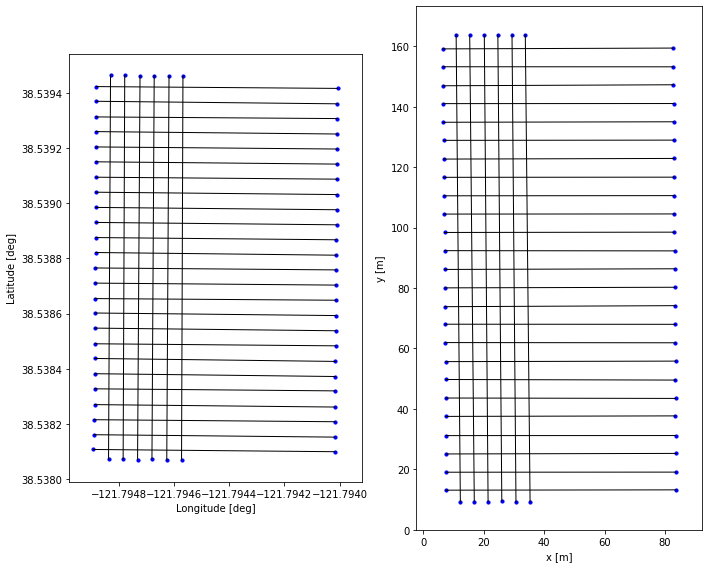

In [5]:
# plot
fig, axes = plt.subplots(1,2,figsize=(10,8))
configure_map_plot(axes[0], 'latlon')
configure_map_plot(axes[1], 'local')

for key in all_data_latlon.keys():
    axes[0].scatter(all_data_latlon[key][:, 0], all_data_latlon[key][:, 1], s=10, color='b')
    axes[1].scatter(all_data_local[key][:, 0], all_data_local[key][:, 1], s=10, color='b')

for i in range(len(treeline_SN_latlon)):
    axes[0].plot(
        treeline_SN_latlon[i][:, 0], treeline_SN_latlon[i][:, 1],
        color='k', linewidth=1.0
    )
    axes[1].plot(
        treeline_SN_local[i][:, 0], treeline_SN_local[i][:, 1],
        color='k', linewidth=1.0
    )

for i in range(len(treeline_WE_latlon)):
    axes[0].plot(
        treeline_WE_latlon[i][:, 0], treeline_WE_latlon[i][:, 1],
        color='k', linewidth=1.0
    )
    axes[1].plot(
        treeline_WE_local[i][:, 0], treeline_WE_local[i][:, 1],
        color='k', linewidth=1.0
    )

fig.tight_layout()


### Draw All

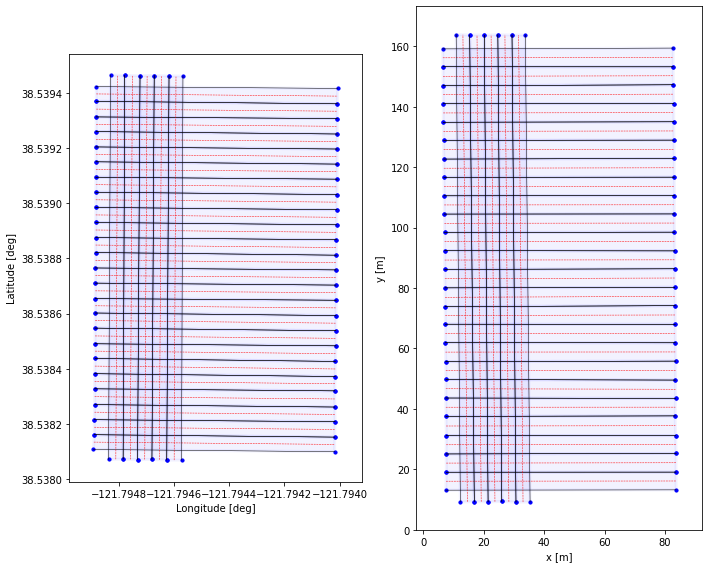

In [6]:
fig, axes = plt.subplots(1,2,figsize=(10, 8))
configure_map_plot(axes[0], 'latlon')
configure_map_plot(axes[1], 'local')

for i in range(24):
    draw_all(axes[0], row_data[i], 'latlon')
    draw_all(axes[1], row_data[i], 'local')

for i in range(5):
    draw_all(axes[0], column_data[i], 'latlon')
    draw_all(axes[1], column_data[i], 'local')

fig.tight_layout()

In [7]:
def get_projection_point2line(point, line):
    p1_p2 = line[1] - line[0]
    p1_q = point[:2] - line[0]
    lateral_proj = np.cross(p1_q, p1_p2 / np.linalg.norm(p1_p2))  # positive means on the right hand side
    longitude_proj = np.dot(p1_q, p1_p2)

    return lateral_proj, longitude_proj

def get_local_xy_from_latlon(lat, lon, utm_T_local):
    e, n, _, _ = utm.from_latlon(lat, lon)
    utm_pose = np.array([e, n, 0, 1]).T
    local_pose = utm_T_local.dot(utm_pose)
    local_pos = local_pose[:3].T

    return local_pos

def find_index(current_pose, all_data, frame='local', start_index=0):
    search_index = np.arange(0, len(all_data))
    search_index_order = (search_index + start_index) % len(all_data)

    for index in search_index_order:
        point = Point(current_pose[0], current_pose[1])
        polygon = Polygon([vertex for vertex in all_data[index]['vertice_' + frame]])

        if polygon.contains(point):
            return index

    return None

### Single data

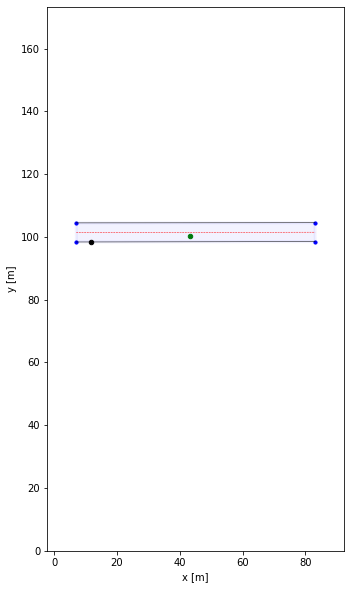

In [8]:
fig, axis = plt.subplots(1,1, figsize=(10,10))
configure_map_plot(axis, 'local')

# drone location
drone_latlon = np.array([-121.794468, 38.53889]) # lon, lat
drone_local_pos = get_local_xy_from_latlon(drone_latlon[1], drone_latlon[0], utm_T_local)
axis.scatter(drone_local_pos[0], drone_local_pos[1], s=20, color='g')

# find which row/column
index = find_index(drone_local_pos, row_data, frame='local')
draw_all(axis, row_data[index], frame='local')

# find projection
lateral_proj, longitude_proj = get_projection_point2line(drone_local_pos, row_data[index]['centerline_local'])
c1 = plt.Circle(drone_local_pos, abs(lateral_proj)/12, alpha=0.1)
axis.add_patch(c1)


# offset
treeline = row_data[index]['treelines_local'][0]
treeline_length = np.linalg.norm(treeline[1] - treeline[0])

offset = 15 * 0.3048 # m
alpha = offset / treeline_length
new_pt = treeline[1] * alpha + (1 - alpha) * treeline[0]
axis.scatter(new_pt[0], new_pt[1], s=20, color='k')
